### Lennard-Jones 2 particle system

In [1]:
from __future__ import annotations
from typing import List, Callable
from functools import partial

In [2]:
import covalent as ct
import numpy as np
import os
from shutil import rmtree
import re
import copy
from covalent import electron

In [3]:
import matplotlib.pyplot as plt

In [4]:
%matplotlib notebook

In [5]:
from matplotlib.animation import FuncAnimation

#### Simulation domain

In [6]:
class Domain(object):
    def __init__(self, xlo: float, xhi: float, ylo: float, yhi: float):
        self.xlo = xlo
        self.xhi = xhi
        self.ylo = ylo
        self.yhi = yhi


    @property
    def lx(self):
        return self.xhi - self.xlo

    @property
    def ly(self):
        return self.yhi - self.ylo

### MD particle

In [7]:
def create_particle(id: int, mass: float, domain: Domain):
    """
    Create a particle with id=`id` and mass=`mass' randomly
    located in the domain
    """
    return Particle(id=id, mass=mass,x=np.random.uniform(),y=np.random.uniform())


class Particle(object):
    def __init__(self, id: int, mass: float, x: float, y: float,
                 vx: float = 0.0, vy: float = 0.0, fx: float = 0.0,
                 fy: float = 0.0):
        """
        Basic particle
        """
        self.id = id
        self.mass = mass
        self.x = x
        self.y = y
        self.vx = vx
        self.vy = vy
        self.fx = fx
        self.fy = fy

    def __eq__(self, other: Particle):
        return all([other.__dict__[key] == value for key, value in
                   self.__dict__.items()])

    def __sub__(self, other: Particle):
        return self.x - other.x, self.y - other.y

    def __repr__(self):
        return f"Particle(id={self.id}, mass={self.mass},x={self.x},\
                y={self.y},vx={self.vx},vy={self.vy},\
                fx={self.fx},fy={self.fy})".replace('\n', '')

    def __str__(self):
        return f"""{self.id},{self.mass},{self.x},{self.y},{self.vx},{self.vy},{self.fx},{self.fy}\n"""

### Potentials

In [8]:
class Potential(object):
    def __init__(self, name: str):
        self.name = name

    def __call__(self, r: float):
        raise NotImplementedError

class LennardJones126(Potential):
    def __init__(self, epsilon: float = 1.0, sigma: float = 1.0,
                 cutoff: float = 2.5):
        self.epsilon = epsilon
        self.sigma = sigma
        self.cutoff = cutoff
        super().__init__(name="lj/126")

    def __call__(self, r: float):
        if r <= self.cutoff:
            return 4*self.epsilon*((self.sigma/r)**12 -
                                   (self.sigma/r)**6)
        return 0.0
    
    
class Harmonic(Potential):
    def __init__(self, k: float = 20.0, r0 = 1.0):
        self.k = k
        self.r0 = r0
        super().__init__(name="harmonic")
        
    def __call__(self, r: float):
        return 0.5*self.k*(r - self.r0)**2

In [9]:
@ct.electron
def check_pbc(x: float, L: float):
    if x > L*0.5:
        return x - L
    if x <= -L*0.5:
        return x + L
    return x

In [12]:
@ct.electron
def total_pe(particles: List[Particle], potential, domain: Domain):
    total = 0.0
    # this can be parallelized!!
    for i in particles:
        for j in particles:
            if i == j:
                continue
            else:
                dx, dy = i - j
                dx = check_pbc(dx, domain.lx)
                dy = check_pbc(dy, domain.ly)
                
                dr = np.sqrt(dx**2 + dy**2)
                total += potential(dr)
    return total/2.0

In [13]:
@ct.electron
def grad_pe(particles: List[Particle], potential, domain: Domain, epsilon: float = 1e-8):
    grad = []
    # this can be parallelized
    for p in particles:
        pe = total_pe(particles=particles, potential=potential, domain=domain)
        p.x += epsilon
        pe_delta = total_pe(particles=particles, potential=potential, domain=domain)
        dudpx = (pe_delta - pe)/epsilon
        p.x -= epsilon
        
        p.y += epsilon
        pe_delta = total_pe(particles=particles, potential=potential, domain=domain)
        dudpy = (pe_delta - pe)/epsilon
        p.y -= epsilon
        
        grad.append(dudpx)
        grad.append(dudpy)
        
    return grad

### Save particles to file

In [14]:
@ct.electron
def save_snapshot(particles: List[Particle], step: int):
    if not os.path.isdir("/home/venkat/agnostiq-rpi-tutorials/snapshots"):
        os.mkdir("/home/venkat/agnostiq-rpi-tutorials/snapshots")
    dump_file=f"/home/venkat/agnostiq-rpi-tutorials/snapshots/system_{step}.txt"
    
    with open(dump_file, "w") as f:
        for particle in particles:
            f.write(str(particle))
        f.close()

In [15]:
@ct.electron
def minimize_system_energy(objective, particles, grad, domain, options = {}, *args, **kwargs):
    """
    Given a system, minimize its potential energy using gradient descent
    """
    try:
        learning_rate = options["learning_rate"]
    except KeyError:
        learning_rate = 1e-3
        
    try:
        tol = options["tol"]
    except KeyError:
        tol = 1e-5
        
    try:
        maxiter = options["maxiter"]
    except KeyError:
        maxiter = 500
        
    try:
        verbose = options["verbose"]
    except KeyError:
        verbose = False
        
    
    x = copy.deepcopy(particles)
    fold = objective(x)
    i = 0
    diff = 1e10
    diff_history = [diff]
    f_history = [fold]
    dx = np.zeros(2*len(x))
        
    while i < maxiter and diff > tol:
        dx = -learning_rate*np.asarray(grad(x))
            
        for index, particle in enumerate(x):
            particle.x += dx[index]
            particle.y += dx[index+1]
                
            particle.x = particle.x%domain.lx
            particle.y = particle.y%domain.ly
            
        #save_snapshot(x, i)
                
        fnew = objective(x)
        diff = np.abs(fnew - fold)
        fold = fnew
        diff_history.append(diff)
        f_history.append(fnew)
        
        if verbose:
            print(i, fnew)
                
        if i % 10 == 0:
            learning_rate /= 2
            
        i += 1
        
    return x, fnew, i

In [16]:
@ct.electron
def gradient_descent_particle_update(particles: List[Particle], dx: List[float], domain: Domain):
    for index, particle in enumerate(particles):
        particle.x += dx[index]
        particle.y += dx[index+1]
        
        particle.x = particle.x%domain.lx
        particle.y = particle.y%domain.ly
        
    return particles

@ct.electron
def check_loss(f_old: float, f_new: float):
    return abs(f_new - f_old)

In [17]:
@ct.electron
def init_velocities(particles: List[Particle]):
    for particle in particles:
        particle.vx = np.random.randn()
        particle.vy = np.random.randn()
    return particles


@ct.electron
def scale_gradients(gradients: List[float], lr: float):
    res = []
    for value in gradients:
        res.append(-1.0*lr*value)
    return res

@ct.electron
def update_learning_rate(lr: float, f: float, step: int):
    if f < 0.0:
        return lr / 4.0
    
    if step % 10 == 0:
        return lr / 2.0
    return lr

In [18]:
@ct.electron
def euler_step(particles, dt: float):
    for particle in particles:
        particle.x += particle.vx*dt
        particle.y += particle.vy*dt
        
    return particles

@ct.electron
def update_forces(particles: List[Particle], potential: Potential, domain: Domain):
    for i in particles:
        i.fx = 0.0
        i.fy = 0.0
        for j in particles:
            if i == j:
                continue
            else:
                dx, dy = i - j
                
                dx = check_pbc(dx, domain.lx)
                dy = check_pbc(dy, domain.ly)
                
                dr = np.sqrt(dx**2 + dy**2)
                                
                f = -(potential(dr+1e-8) - potential(dr-1e-8))/(2*1e-8)
                
                fx = (dx/dr)*f
                fy = (dy/dr)*f
                
                i.fx += fx/2.0
                i.fy += fy/2.0
    return particles


@ct.electron
def verlet_integration(step: int, particles: List[Particles], particles_prev: List[Particles],
                       potential: Potential, domain: Domain,dt: float):
    p_copy = copy.deepcopy(particles)

    if step == 0:
        for particle in particles:
            particle.x += particle.vx*dt
            particle.y += particle.vy*dt
            
            particle.x = particle.x%domain.lx
            particle.y = particle.y%domain.ly
    else:
        particles = update_forces(particles, potential, domain)
    
        for index, particle in enumerate(particles):
            particle.x = 2*particle.x - particles_prev[index].x + particle.fx*dt**2
            particle.y = 2*particle.y - particles_prev[index].y + particle.fy*dt**2
            particle.x = particle.x%domain.lx
            particle.y = particle.y%domain.ly
        
    return particles, p_copy

In [19]:
@ct.electron
def velocity_verlet_integration(particles: List[Particle], potential, domain, dt):
    particles = update_forces(particles, potential, domain)

    # Update positions
    for particle in particles:
        particle.x = particle.x + particle.vx*dt + (particle.fx/(2*particle.mass))*dt**2
        particle.y = particle.y + particle.vy*dt + (particle.fy/(2*particle.mass))*dt**2
        particle.x = particle.x%domain.lx
        particle.y = particle.y%domain.ly
        
    # Update forces
    particles_copy = update_forces(particles, potential, domain)
    
    # Update velocities
    for index, particle in enumerate(particles):
        particle.vx = particle.vx + dt*(particles_copy[index].fx+particle.fx)/(2*particle.mass)
        particle.vy = particle.vy + dt*(particles_copy[index].fy+particle.fy)/(2*particle.mass)
        
    return particles

In [20]:
@ct.electron
def run(nsteps, particles: List[Particles], potential: Potential, domain: Domain, dt: float):
    for i in range(nsteps):
        particles = velocity_verlet_integration(particles=particles, potential=potential, domain=domain, dt=dt)
        
        save_snapshot(particles, i)
    return particles

### Workflow with steps broken down

In [21]:
@ct.lattice
def refined_simulation(particles: List[Particle], domain: Domain, potential: Potential,
                       nsteps, dt, maxiter: int = 1, lr: float=1e-3):
    i = 0
    tol = 1e-5
    f_old = total_pe(particles, potential, domain=domain)
    
    # Minimize system energy
    objective = partial(total_pe, potential=potential, domain=domain)
    gradient = partial(grad_pe, potential=potential, domain=domain)
    
    loss_value = 1e10
    
    for i in range(maxiter):
        gradients = gradient(particles)
        dx = scale_gradients(gradients=gradients, lr=lr)
        
        # update particle positions
        particles = gradient_descent_particle_update(particles=particles, dx=dx, domain=domain)
        
        # Save system
        save_snapshot(particles, i)
        
        # Compute new energy
        f_new = objective(particles)
        
        # Check loss
        loss_value = check_loss(f_old=f_old, f_new=f_new, tol=1e-6)
        
        f_old = f_new
        
        lr = update_learning_rate(lr, f_new, i)
        
        i += 1
        
        
    # Run dynamics
        
    return particles

In [24]:
@ct.lattice
def simulation(particles: List[Particle], domain: Domain, potential: Potential, nsteps):
    """
    run a basic MD particle simulation
    """
    i = 0
    # Compute the system initial potential energy
    f_old = total_pe(particles, potential, domain=domain)
    
    # Minimize system energy
    objective = partial(total_pe, potential=potential, domain=domain)
    gradient = partial(grad_pe, potential=potential, domain=domain)
    
    #loss_value = 1e10
    
    #for i in range(maxiter):
    #    gradients = gradient(particles)
    #    dx = scale_gradients(gradients=gradients, lr=lr)
        
        # Update particle positions
    #    particles = gradient_descent_particle_update(particles=particles, dx=dx, domain=domain)
        
        # Save system
    #    save_snapshot(particles, i)
        
        # Compute potential energy
    #    f_new = objective(particles)
        
        # Check loss
    #    loss = check_loss(f_old=f_old, f_new=f_new, tol=tol)
        
    #    f_old = f_new
        
        # update learning rate based on f_new and step
    #    lr = update_learning_rate(lr, f_new, i)
        
    #    i += 1
        
    particles, final_energy, num_iterations = minimize_system_energy(objective, particles, gradient, domain,
                                                                     options={"maxiter": 200, "tol": 1e-5,
                                                                              "learning_rate": 1e-2,
                                                                              "verbose": True})
    
    
    # Initialize velocities
    particles = init_velocities(particles)
    
    
    # Compute total energy
    #pe = total_pe(particles=particles, potential=potential, domain=domain)
    
    #ke = total_ke(particles=particles)
    
    #total_energy = pe + ke
    
    # Integrate
    particles = run(nsteps=nsteps,
                    particles=particles,
                    potential=potential,
                    domain = domain,
                    dt=1e-2)
        
    
    # Start integrating
    #p0 = particles # copy

    #for i in range(nsteps):
        # p2
    #    particles, p1 = verlet_integration(step=i, particles=particles, particles_prev=p0,
    #                                       potential=potential, domain=domain, dt=1e-4)
    #    p0 = p1
        
    #    save_snapshot(particles, i)
        

    return {"particles": particles, "iters": nsteps}

In [25]:
domain = Domain(xlo = 0, xhi = 5, ylo = 0, yhi = 5)
num_particles = 5
nsteps = 1000
particles = [create_particle(id=index, mass=1.0, domain = domain) for index in range(num_particles)]

if os.path.isdir("/home/venkat/agnostiq-rpi-tutorials/snapshots"):
    rmtree("/home/venkat/agnostiq-rpi-tutorials/snapshots")
    
#res = simulation(particles, domain, LennardJones126(), nsteps)

In [26]:
res = ct.dispatch_sync(simulation)(particles, domain, LennardJones126(), nsteps)

In [68]:
res = ct.dispatch_sync(refined_simulation)(particles, domain, LennardJones126(), nsteps, 1e-2)

In [69]:
res.result

[Particle(id=0, mass=1.0,x=4.279434377056077,                y=2.0089267170094303,vx=0.0,vy=0.0,                fx=0.0,fy=0.0),
 Particle(id=1, mass=1.0,x=1.5856222151292272,                y=4.265441592782736,vx=0.0,vy=0.0,                fx=0.0,fy=0.0),
 Particle(id=2, mass=1.0,x=3.934287879616022,                y=4.208300292491913,vx=0.0,vy=0.0,                fx=0.0,fy=0.0),
 Particle(id=3, mass=1.0,x=4.19215315580368,                y=4.294094381231389,vx=0.0,vy=0.0,                fx=0.0,fy=0.0),
 Particle(id=4, mass=1.0,x=4.2144032284418245,                y=3.4456057838528977,vx=0.0,vy=0.0,                fx=0.0,fy=0.0)]

In [70]:
def animate(frame_number):
    data = np.loadtxt(f"snapshots/system_{frame_number}.txt", delimiter=",")
    x = data[:, 2]
    y = data[:, 3]
    line.set_data((x, y))
    return line

<IPython.core.display.Javascript object>


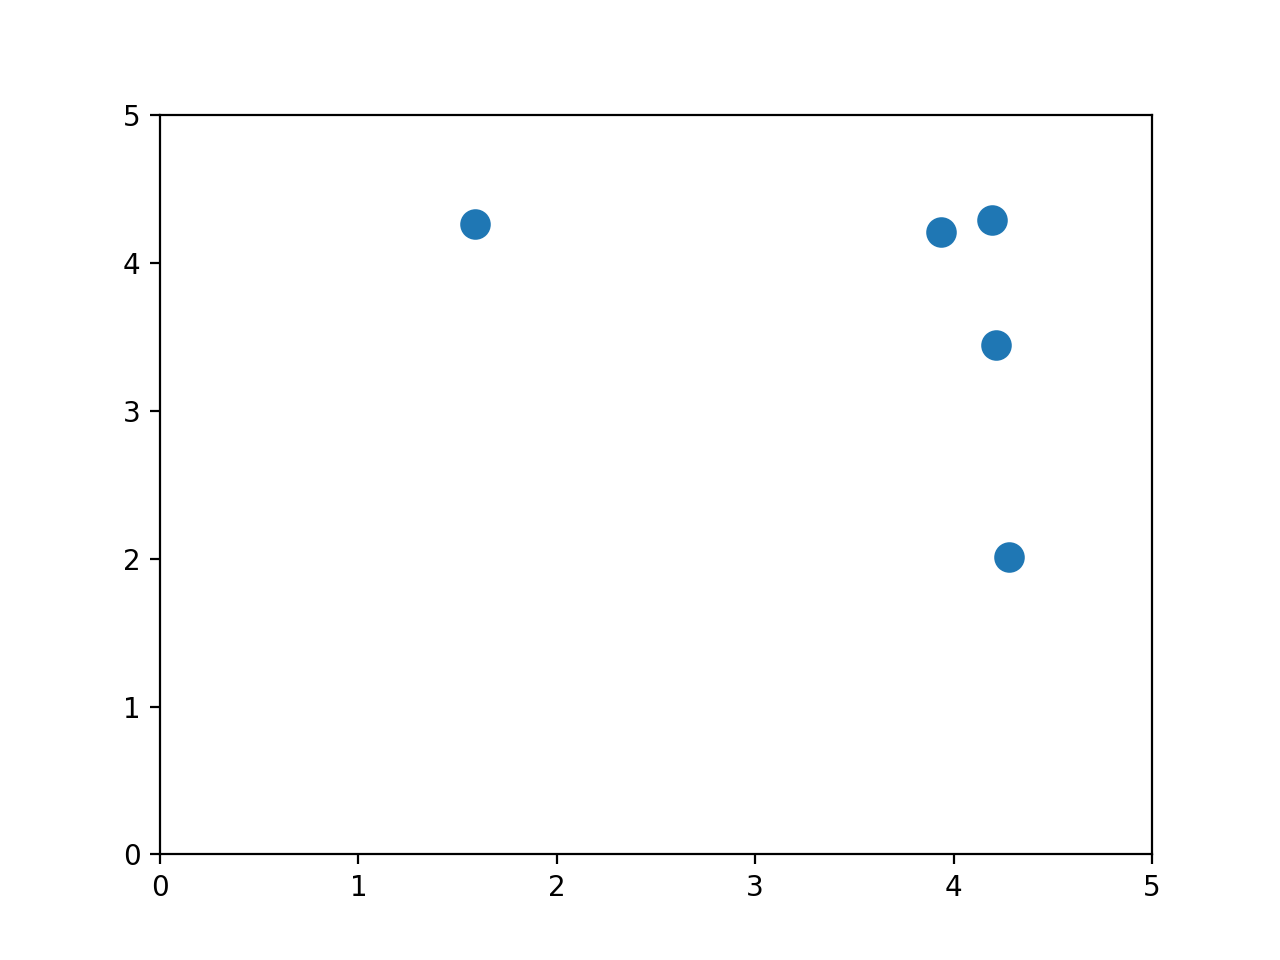

In [71]:
fig, ax = plt.subplots()

line, = ax.plot([], 'o', ms=10)     # A tuple unpacking to unpack the only plot
ax.set_xlim(domain.xlo, domain.xhi)
ax.set_ylim(domain.ylo, domain.yhi)

anim = FuncAnimation(fig, animate, frames=nsteps, interval=50)

plt.show()

### When to unroll

### checkpointing: larger system sizes
### scale to more devices
### use parallelization
### visual aspect of it

### viewing progress of your run!

### hands-on portion of this
##### using different potentials
##### simple parallelizing
##### begineer one these are the steps that ought to happen
##### construct a workflow (turn it into a lattice)
##### look at where the bottle neck it (it can be parallelized)
#### keep it short enough, but open ended (parallelize with joblib)